In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import os
from mido.midifiles.meta import KeySignatureError
from mido import MidiFile
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from functools import partial
from copy import deepcopy
from base import BaseModel

In [2]:
test_path = 'samples/music/maestro/'

files = os.listdir(test_path)
mpb = []
tpb = []
f_files = []
rolls = []
for f in sorted(files)[:100]:
    try:
        t = 0
        note_found = False
        discard = False
        mpb_i = None
        mid_temp = MidiFile(os.path.join(test_path, f), clip=True)
        notes = {
            n: {'start': [], 'end': [], 'velocity': []}
            for n in range(128)
        }
        for track in mid_temp.tracks:
            for msg in track:
                if not msg.is_meta:
                    if msg.type == 'note_on':
                        if note_found:
                            t += msg.time
                        else:
                            t = 0
                            note_found = True
                        if msg.velocity > 0:
                            notes[msg.note]['start'].append(t // mid_temp.ticks_per_beat)
                            notes[msg.note]['velocity'].append(msg.velocity)
                        else:
                            notes[msg.note]['end'].append(t // mid_temp.ticks_per_beat)
                    if msg.type == 'note_off':
                        t += msg.time
                        notes[msg.note]['end'].append(t // mid_temp.ticks_per_beat)
                else:
                    if msg.type == 'set_tempo':
                        if mpb_i is None:
                            mpb_i = msg.tempo
                        else:
                            discard = True
                    elif msg.type == 'time_signature':
                        if msg.numerator != 4 and  msg.denominator != 4:
                            print(msg)

        if not discard:
            f_files.append(f) 
            tpb.append(mid_temp.ticks_per_beat)
            mpb.append(mpb_i)
            piano_roll = np.zeros((128, t // mid_temp.ticks_per_beat))
            for n, events in notes.items():
                if len(events['start']) > 0:
                    for n_ini, n_end, v in zip(events['start'], events['end'], events['velocity']):
                        piano_roll[n, n_ini:n_end] = v / 127
            rolls.append(piano_roll)
    except EOFError:
        pass

In [3]:
def accuracy_logits(logits, target):
    prediction = torch.max(logits, dim=1)[1]
    return 1 - (prediction == target).float().mean()
    
    
class SelfAttentionBlock(nn.Module):
    def __init__(self, embed_dim, mlp_dim, heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attention = nn.MultiheadAttention(
            embed_dim, heads, batch_first=True
        )
        self.ln2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = nn.Linear(embed_dim, mlp_dim)

    def forward(self, x_in, mask=None):
        x = self.ln1(x_in)
        x, _ = self.attention(
            query=x, key=x, value=x, attn_mask=mask,
            need_weights=False,
        )
        x = x + x_in

        y = self.ln2(x)
        y = self.mlp(y)

        return x + y
    

class MusicTransformer(BaseModel):
    """
        Transformer architecture for motifs inspired by
        C.-Z. A. Huang, A. Vaswani, J. Uszkoreit, N. Shazeer,
        I. Simon, C. Hawthorne, A. M. Dai, M. D. Hoffman,
        M. Dinculescu and D. Eck
        "Music Transformer"
        https://arxiv.org/abs/1809.04281
    """
    def __init__(
        self,
        encoder_depth=16,
        decoder_depth=16,
        device=torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu"
        ),
        notes=128,
        bits=8,
        multitokens=True,
        heads=32,
        lr=1e-3,
        verbose=0,
    ):
        super().__init__()
        # Init values
        self.epoch = None
        self.t_train = 0
        self.t_val = 0
        self.heads = heads
        self.device = device
        self.multitokens = multitokens
        if self.multitokens:            
            channels = notes
        else:
            channels = 2 * notes + bits

        # <Parameter setup>
        self.encoder = nn.ModuleList([
            SelfAttentionBlock(channels, channels, heads)
            for _ in range(encoder_depth)
        ])
        self.decoder = nn.ModuleList([
            SelfAttentionBlock(channels, channels, heads)
            for _ in range(decoder_depth)
        ])

        # <Loss function setup>
        if self.multitokens:
            self.train_functions = [
                {
                    'name': 'xent',
                    'weight': 1,
                    'f': F.binary_cross_entropy_with_logits
                },
            ]
            
            self.val_functions = [
                {
                    'name': 'xent',
                    'weight': 1,
                    'f': F.binary_cross_entropy_with_logits
                },
                {
                    'name': 'mse',
                    'weight': 0,
                    'f': lambda p, t: F.mse_loss(
                        torch.sigmoid(p), t,
                    )
                },
                {
                    'name': 'l1',
                    'weight': 0,
                    'f': lambda p, t: F.l1_loss(
                        torch.sigmoid(p), t,
                    )
                },
                {
                    'name': '0mse',
                    'weight': 0,
                    'f': lambda p, t: F.mse_loss(
                        torch.zeros_like(t).to(t.device), t,
                    )
                },
                {
                    'name': '1mse',
                    'weight': 0,
                    'f': lambda p, t: F.mse_loss(
                        torch.ones_like(t).to(t.device), t,
                    )
                },
            ]
        else:
            self.train_functions = [
                {
                    'name': 'xent',
                    'weight': 1,
                    'f': F.cross_entropy
                },
            ]
            
            self.val_functions = [
                {
                    'name': 'xent',
                    'weight': 0,
                    'f': F.cross_entropy
                },
                {
                    'name': 'acc',
                    'weight': 1,
                    'f': accuracy_logits
                },
            ]

        # <Optimizer setup>
        # We do this last step after all parameters are defined
        model_params = filter(lambda p: p.requires_grad, self.parameters())
        # self.optimizer_alg = torch.optim.Adam(model_params, lr=lr)
        self.optimizer_alg = torch.optim.SGD(model_params, lr=lr)
        self.schedulers = [
#             torch.optim.lr_scheduler.ExponentialLR(
#                 self.optimizer_alg, gamma=0.9
#             ),
#             torch.optim.lr_scheduler.MultiStepLR(
#                 self.optimizer_alg, milestones=[10, 30, 50, 80, 100, 150], gamma=0.1
#             ),
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer_alg, 'min'
            )
        ]
        if verbose > 1:
            print(
                'Network created on device {:} with training losses '
                '[{:}] and validation losses [{:}]'.format(
                    self.device,
                    ', '.join([tf['name'] for tf in self.train_functions]),
                    ', '.join([vf['name'] for vf in self.val_functions])
                )
            )

    def forward(self, data):
        N, F, L = data.shape
        mask = torch.ones((L, L), dtype=bool)
        mask = torch.logical_not(torch.triu(mask)).to(self.device)
        seq_range = torch.arange(0, data.shape[-1])
        x_cord, y_cord = torch.meshgrid(seq_range, seq_range)
        s_rel = 1 - torch.abs(x_cord - y_cord).type_as(data).to(data.device)
        snorm_rel = s_rel / L
        data = data.transpose(-1, -2)
        for i, e_tf in enumerate(self.encoder):
            e_tf.to(self.device)
            data = e_tf(data, snorm_rel)
        for i, d_tf in enumerate(self.decoder):
            d_tf.to(self.device)
            data = d_tf(data, mask)
        return data.transpose(-1, -2)

    def next_beat(self, motif):
        self.eval()
        with torch.no_grad():
            tensor_motif = torch.from_numpy(
                np.expand_dims(motif, axis=0)
            ).to(self.device)
            if self.multitokens:
                next_beat = torch.sigmoid(self(tensor_motif))
            else:
                next_beat = torch.softmax(self(tensor_motif), dim=1)

        return next_beat.detach().cpu().numpy()[0, ...]

    def song(self, motif, n_beats):
        song_list = [motif]
        song = [motif]
        for _ in range(n_beats):
            beat = self.next_beat(motif)
            new_notes = deepcopy(beat)
            if self.multitokens:
                motif = (new_notes > 0.5).astype(np.float32)
                song_list.append(
                    beat
                )
                song.append(
                    new_notes > 0.5
                )
            else:
                new_tokens = deepcopy(beat)
                max_val = np.max(new_tokens, axis=0, keepdims=True)
                motif = (new_tokens == max_val).astype(np.float32)
                song_list.append(
                    beat
                )
                song.append(
                    new_tokens == max_val
                )

        return np.concatenate(song_list, axis=1), np.concatenate(song, axis=1)

In [4]:
class MotifDataset(Dataset):
    def __init__(
            self, paths=None, motif_size=64, notespbeat=12,
            bits=8, multitokens=True
    ):
        # Init
        if paths is None:
            paths = ['samples/music/jazz/', 'samples/music/classical/']
        self.multitokens = multitokens
        self.motif_size = motif_size
        self.rolls = []
        self.states = []
        self.bits = bits
        min_len = 2 * self.motif_size + 1
        beat = 0
        for path in paths:
            files = sorted(os.listdir(path))
            for f in files:
                t = 0
                discard = False
                mpb_i = None
                note_found = False
                try:
                    mid_temp = MidiFile(os.path.join(path, f), clip=True)
                    notes = {
                        n: {'start': [], 'end': [], 'velocity': []}
                        for n in range(128)
                    }
                    tpb = mid_temp.ticks_per_beat
                    for track in mid_temp.tracks:
                        for msg in track:
                            if not msg.is_meta:
                                if note_found:
                                    t += msg.time
                                if msg.type == 'note_on':
                                    if not note_found:
                                        t = 0
                                        note_found = True
                                    beat = t // tpb
                                    if msg.velocity > 0:
                                        notes[msg.note]['start'].append(beat)
                                        notes[msg.note]['velocity'].append(
                                            msg.velocity
                                        )
                                    else:
                                        notes[msg.note]['end'].append(beat)
                                elif msg.type == 'note_off':
                                    beat = t // tpb
                                    notes[msg.note]['end'].append(beat)
                            else:
                                if msg.type == 'set_tempo':
                                    if mpb_i is None:
                                        mpb_i = msg.tempo
                                    else:
                                        discard = True
                                        break
                                elif msg.type == 'time_signature':
                                    num = msg.numerator
                                    den = msg.denominator
                                    if num != 4 and den != 4:
                                        discard = True
                                        break

                    if not discard:
                        piano_roll = np.zeros((128, beat))
                        for n, events in notes.items():
                            if len(events['start']) > 0:
                                for n_ini, n_end, v in zip(
                                        events['start'], events['end'],
                                        events['velocity']
                                ):
                                    # piano_roll[n, n_ini:n_end] = v / 127
                                    piano_roll[n, n_ini:n_end] = 1
                        max_notes = np.max(
                            np.sum(piano_roll, axis=0)
                        ).astype(int)
                        piano_state = roll_to_state(
                            piano_roll, bits=self.bits
                        )
                        roll_len = piano_roll.shape[1]
                        if roll_len > min_len and max_notes < notespbeat:
                            self.rolls.append(piano_roll)
                        state_len = piano_state.shape[1]
                        if state_len > min_len and max_notes < notespbeat:
                            self.states.append(piano_state)
                except (EOFError, OSError, KeySignatureError):
                    print('Unreadable', f, path)

        max_notes = [
            np.max(np.sum(roll, axis=0)).astype(int)
            for roll in self.rolls
        ]
        print(
            '{:d} piano rolls loaded with '
            '[{:02d}, {:02d}] - {:5.3f} ± {:5.3f} '
            'maximum consecutive notes'.format(
                len(self.rolls), np.min(max_notes), np.max(max_notes),
                np.mean(max_notes), np.std(max_notes)
            )
        )

    def __getitem__(self, index):
        if self.multitokens:
            song = self.rolls[index]
        else:
            song = self.states[index]
        max_ini = song.shape[1] - (2 * self.motif_size)
        data_ini = np.random.randint(0, max_ini)
        target_ini = data_ini + self.motif_size
        data = song[:, data_ini:target_ini].astype(np.float32)
        target = song[:, target_ini:(target_ini + self.motif_size)].astype(np.float32)
        if not self.multitokens:
            target = np.argmax(target, axis=0)

        return data, target

    def __len__(self):
        if self.multitokens:
            n_samples = len(self.rolls)
        else:
            n_samples = len(self.states)
        return n_samples

In [5]:
def shift_tokens(shift, bits=4, notes=128):
    remainder = shift
    tokens = []
    for shift_bit in range(bits - 1, -1, -1):
        token = np.zeros(2 * notes + bits)
        token[2 * notes + shift_bit] = 1
        n_tokens = remainder // 2 ** shift_bit
        remainder = remainder - n_tokens * 2 ** shift_bit
        tokens += n_tokens * [token]
        
    return tokens


def on_tokens(note_list, bits=4, notes=128):
    tokens = []
    for note in note_list:
        token = np.zeros(2 * notes + bits)
        token[note] = 1
        tokens.append(token)
        
    return tokens


def off_tokens(note_list, bits=4, notes=128):
    tokens = []
    for note in note_list:
        token = np.zeros(2 * notes + bits)
        token[notes + note] = 1
        tokens.append(token)
        
    return tokens


def roll_to_state(roll, bits=8, notes=128):
    shift = 0
    notes_active = np.array([])
    token_list = []
    for beat in roll.transpose():
        if np.sum(beat) > 0:
            played_notes = np.where(beat > 0)[0]
            new_replayed = np.isin(played_notes, notes_active)
            old_replayed = np.isin(notes_active, played_notes)
            if new_replayed.all() and old_replayed.all():
                # We are repeating everything
                # print('Repeat', notes_active, played_notes, shift)
                pass
            else:
                # Changes
                on = played_notes[np.logical_not(new_replayed)]
                off = notes_active[np.logical_not(old_replayed)]
                # print(
                #     'OFF', off, 'ON', on, 'Data', notes_active, old_replayed,
                #     played_notes, new_replayed, shift
                # )
                token_list += shift_tokens(shift, bits, notes)
                token_list += off_tokens(off, bits, notes)
                token_list += on_tokens(on, bits, notes)
                shift = 0
            notes_active = played_notes
        else:
            if len(notes_active) == 0:
                # Silence
                # print('Silence', shift)
                pass
            else:
                # Notes go off
                # print('OFF', notes_active, shift)
                token_list += shift_tokens(shift, bits, notes)
                token_list += off_tokens(notes_active, bits, notes)
                notes_active = np.array([])
                shift = 0

        shift += 1
        
    token_list += shift_tokens(shift, bits, notes)
    
    return np.stack(token_list, axis=1)


def state_to_roll(states, bits=8, notes=128):
    roll = []
    active_notes = []
    for state in states.transpose():
        state_code = np.where(state)[0][0]
        if state_code < notes:
            # print('ON', state_code)
            active_notes.append(state_code)
        elif state_code < (2 * notes):
            # print('OFF', state_code - notes)
            try:
                active_notes.remove(state_code - notes)
            except ValueError:
                pass
        else:
            # print('Shift', 2 ** (state_code - 2 * notes))
            shift = 2 ** (state_code - 2 * notes)
            beat = np.zeros(notes)
            for note in active_notes:
                beat[note] = 1
            roll += shift * [beat]
    
    return np.stack(roll, axis=1)    

In [6]:
motif_size = 32
bits = 16
paths = [
    'samples/music/giantpiano/',
    'samples/music/classical/',
    'samples/music/jazz/',
#     'samples/music/maestro/',
    'samples/music/mfiles/',
    'samples/music/midiworld/',
]
dataset = MotifDataset(paths, motif_size=motif_size, bits=bits, notespbeat=20, multitokens=True)

Unreadable Leifs, Jón, 4 Piano Pieces, Op.2, qgJ2dV6L3Ac.mid samples/music/giantpiano/
Unreadable Liszt, Franz, Concerto pathétique, S.258, VkZPzfwL0xw.mid samples/music/giantpiano/
Unreadable ballade2.mid samples/music/midiworld/
Unreadable dsch10-1.mid samples/music/midiworld/
Unreadable dsch10-2.mid samples/music/midiworld/
Unreadable dsch10-3.mid samples/music/midiworld/
Unreadable dsch10-4.mid samples/music/midiworld/
Unreadable festivgs.mid samples/music/midiworld/
Unreadable feux.mid samples/music/midiworld/
Unreadable gadflycontradance.mid samples/music/midiworld/
Unreadable gadflyfolk.mid samples/music/midiworld/
Unreadable gadflygalop.mid samples/music/midiworld/
Unreadable gadflyromance.mid samples/music/midiworld/
Unreadable gadflywaltz.mid samples/music/midiworld/
Unreadable liszt1-1.mid samples/music/midiworld/
Unreadable liszt1-2.mid samples/music/midiworld/
Unreadable liszt1-3.mid samples/music/midiworld/
Unreadable mazeppa.mid samples/music/midiworld/
Unreadable op87

In [7]:
batch_size = 32

net_multi = MusicTransformer(encoder_depth=128, decoder_depth=128, multitokens=True, heads=16)
n_param = sum(
    p.numel() for p in net_multi.parameters() if p.requires_grad
)
print('Network ready {:d} parameters'.format(n_param))

dataset.multitokens = True
train_loader = DataLoader(
    dataset, batch_size, True, num_workers=1
)
val_loader = DataLoader(
    dataset, batch_size, num_workers=1
)

net_multi.fit(train_loader, val_loader, epochs=200, patience=200)
net_multi.save_model('weights/all_multi.pt')

Network ready 21266432 parameters


/home/mariano/p37/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/mariano/p37/lib/python3.7/site-packages/torch/nn/modules/activation.py:1125: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at  ../aten/src/ATen/native/transformers/attention.cpp:143.)
  average_attn_weights)


Epoch num |  train  |   val   |   xent   |   mse    |    l1    |   0mse   |   1mse   |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
----------|---------|---------|----------|----------|----------|----------|----------|
Init      |  4.4362 |  4.4402 |   4.4402 |   0.4651 |   0.5010 |   0.0286 |   0.9714 | 37s
Epoch 000 |  0.6834 |  0.4435 |   0.4435 |   0.0805 |   0.1074 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                 

Epoch 012 |  0.1201 |  0.1628 |   0.1628 |   0.0398 |   0.0681 |   0.0283 |   0.9717 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 013 |  0.1203 |  0.1604 |   0.1604 |   0.0393 |   0.0677 |   0.0284 |   0.9716 | 2m 21s                                                                                                                                                                                                                                                                                                                                                                                  

Epoch 025 |  0.1118 |  0.1401 |   0.1401 |   0.0346 |   0.0623 |   0.0285 |   0.9715 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Epoch 026 |  0.1115 |  0.1375 |   0.1375 |   0.0341 |   0.0618 |   0.0283 |   0.9717 | 2m 21s                                                                                                                                                                                                                                                                                                                                                                

Epoch 038 |  0.1092 |  0.1327 |   0.1327 |   0.0329 |   0.0606 |   0.0287 |   0.9713 | 2m 19s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Epoch 039 |  0.1075 |  0.1296 |   0.1296 |   0.0324 |   0.0599 |   0.0286 |   0.9714 | 2m 20s                                                                                                                                                                                                                                                                                                                            

Epoch 051 |  0.1065 |  0.1264 |   0.1264 |   0.0316 |   0.0594 |   0.0285 |   0.9715 | 2m 21s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 052 |  0.1068 |  0.1259 |   0.1259 |   0.0316 |   0.0596 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                                                                                                                                                                                                   

Epoch 064 |  0.1041 |  0.1220 |   0.1220 |   0.0307 |   0.0585 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 065 |  0.1041 |  0.1220 |   0.1220 |   0.0307 |   0.0584 |   0.0285 |   0.9715 | 2m 20s                                                                                                                                                                                                                                                                                                                   

Epoch 077 |  0.1028 |  0.1205 |   0.1205 |   0.0303 |   0.0577 |   0.0285 |   0.9715 | 2m 19s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Epoch 078 |  0.1024 |  0.1189 |   0.1189 |   0.0299 |   0.0572 |   0.0284 |   0.9716 | 2m 19s                                                                                                                                                                                                                                                                                                                            

Epoch 090 |  0.1023 |  0.1178 |   0.1178 |   0.0297 |   0.0571 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Epoch 091 |  0.1020 |  0.1170 |   0.1170 |   0.0296 |   0.0571 |   0.0283 |   0.9717 | 2m 20s                                                                                                                                                                                                                                                                                                                            

Epoch 103 |  0.1012 |  0.1162 |   0.1162 |   0.0294 |   0.0568 |   0.0286 |   0.9714 | 2m 17s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 104 |  0.1018 |  0.1160 |   0.1160 |   0.0294 |   0.0571 |   0.0284 |   0.9716 | 2m 18s                                                                                                                                                                                                                                                                                                                   

Epoch 116 |  0.1006 |  0.1153 |   0.1153 |   0.0293 |   0.0565 |   0.0287 |   0.9713 | 2m 19s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Epoch 117 |  0.1010 |  0.1156 |   0.1156 |   0.0294 |   0.0573 |   0.0285 |   0.9715 | 2m 20s                                                                                                                                                                                                                                                                                                                            

Epoch 129 |  0.1001 |  0.1143 |   0.1143 |   0.0289 |   0.0562 |   0.0285 |   0.9715 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 130 |  0.0998 |  0.1132 |   0.1132 |   0.0287 |   0.0560 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                                                                                                                                                                                                   

Epoch 142 |  0.0986 |  0.1138 |   0.1138 |   0.0288 |   0.0562 |   0.0285 |   0.9715 | 2m 19s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Epoch 143 |  0.0997 |  0.1132 |   0.1132 |   0.0288 |   0.0560 |   0.0285 |   0.9715 | 2m 20s                                                                                                                                                                                                                                                                                                                            

Epoch 155 |  0.0997 |  0.1129 |   0.1129 |   0.0287 |   0.0560 |   0.0286 |   0.9714 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 156 |  0.0997 |  0.1127 |   0.1127 |   0.0287 |   0.0559 |   0.0285 |   0.9715 | 2m 19s                                                                                                                                                                                                                                                                                                                   

Epoch 168 |  0.0991 |  0.1125 |   0.1125 |   0.0286 |   0.0558 |   0.0285 |   0.9715 | 2m 21s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 169 |  0.0995 |  0.1124 |   0.1124 |   0.0285 |   0.0557 |   0.0283 |   0.9717 | 2m 20s                                                                                                                                                                                                                                                                                                                   

Epoch 181 |  0.0991 |  0.1131 |   0.1131 |   0.0287 |   0.0558 |   0.0285 |   0.9715 | 2m 19s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 182 |  0.0992 |  0.1118 |   0.1118 |   0.0284 |   0.0555 |   0.0283 |   0.9717 | 2m 20s                                                                                                                                                                                                                                                                                                                   

Epoch 194 |  0.0992 |  0.1123 |   0.1123 |   0.0285 |   0.0556 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Epoch 195 |  0.0992 |  0.1131 |   0.1131 |   0.0286 |   0.0557 |   0.0284 |   0.9716 | 2m 20s                                                                                                                                                                                                                                                                                                                   

In [8]:
batch_size = 32

net_state = MusicTransformer(bits=bits, encoder_depth=128, decoder_depth=128, multitokens=False, heads=16)
n_param = sum(
    p.numel() for p in net_state.parameters() if p.requires_grad
)
print('Network ready {:d} parameters'.format(n_param))

dataset.multitokens = False
train_loader = DataLoader(
    dataset, batch_size, True, num_workers=1
)
val_loader = DataLoader(
    dataset, batch_size, num_workers=1
)

net_state.fit(train_loader, val_loader, epochs=200, patience=200)
net_state.save_model('weights/all_state.pt')

Network ready 95326208 parameters
Epoch num |  train  |   val   |   xent   |   acc    |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
----------|---------|---------|----------|----------|
Init      | 29.5444 |  0.9965 |  29.5832 |   0.9965 | 37s
Epoch 000 | 31.4094 |  0.9920 |  26.4815 |   0.9920 | 2m 16s                                                                                                                                                                                                  

Epoch 012 |  4.4799 |  0.9411 |   6.5506 |   0.9411 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
Epoch 013 |  4.1744 |  0.9630 |   6.2020 |   0.9630 | 2m 15s                                                                                                                                                                                                                                                                                                                                                             

Epoch 025 |  4.1431 |  0.9638 |   6.1481 |   0.9638 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
Epoch 026 |  4.1393 |  0.9620 |   6.1735 |   0.9620 | 2m 16s                                                                                                                                                                                                                                                                                                                                                             

Epoch 038 |  4.1436 |  0.9621 |   6.1480 |   0.9621 | 2m 15s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 039 |  4.1422 |  0.9616 |   6.1568 |   0.9616 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 051 |  4.1386 |  0.9625 |   6.1453 |   0.9625 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 052 |  4.1523 |  0.9631 |   6.1572 |   0.9631 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 064 |  4.1435 |  0.9628 |   6.1670 |   0.9628 | 2m 15s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 065 |  4.1420 |  0.9635 |   6.1755 |   0.9635 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 077 |  4.1430 |  0.9626 |   6.1736 |   0.9626 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 078 |  4.1541 |  0.9632 |   6.1567 |   0.9632 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 090 |  4.1445 |  0.9624 |   6.1625 |   0.9624 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 091 |  4.1452 |  0.9626 |   6.1647 |   0.9626 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 103 |  4.1408 |  0.9625 |   6.1548 |   0.9625 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 104 |  4.1380 |  0.9631 |   6.1643 |   0.9631 | 2m 15s                                                                                                                                                                                                                                                                                                                                                    

Epoch 116 |  4.1488 |  0.9641 |   6.1608 |   0.9641 | 2m 15s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 117 |  4.1531 |  0.9629 |   6.1864 |   0.9629 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 129 |  4.1507 |  0.9626 |   6.1527 |   0.9626 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 130 |  4.1425 |  0.9624 |   6.1631 |   0.9624 | 2m 16s                                                                                                                                                                                                                                                                                                                                                    

Epoch 142 |  4.1388 |  0.9631 |   6.1650 |   0.9631 | 2m 15s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 143 |  4.1474 |  0.9634 |   6.1737 |   0.9634 | 2m 15s                                                                                                                                                                                                                                                                                                                                                    

Epoch 155 |  4.1487 |  0.9619 |   6.1592 |   0.9619 | 2m 15s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 156 |  4.1486 |  0.9622 |   6.1581 |   0.9622 | 2m 15s                                                                                                                                                                                                                                                                                                                                                    

Epoch 168 |  4.1438 |  0.9632 |   6.1760 |   0.9632 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 169 |  4.1459 |  0.9628 |   6.1666 |   0.9628 | 2m 15s                                                                                                                                                                                                                                                                                                                                                    

Epoch 181 |  4.1457 |  0.9629 |   6.1761 |   0.9629 | 2m 15s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 182 |  4.1460 |  0.9629 |   6.1703 |   0.9629 | 2m 15s                                                                                                                                                                                                                                                                                                                                                    

Epoch 194 |  4.1401 |  0.9625 |   6.1664 |   0.9625 | 2m 16s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
Epoch 195 |  4.1376 |  0.9632 |   6.1537 |   0.9632 | 2m 15s                                                                                                                                                                                                                                                                                                                                                    

In [19]:
rand_idx = np.random.randint(0, len(rolls))
random_roll = rolls[rand_idx]
random_tpb = tpb[rand_idx]
random_motif = random_roll[:, :motif_size].astype(np.float32)
random_vel = np.mean(random_motif[random_motif > 0])
song = random_roll[:, :motif_size + motif_size] 

[]

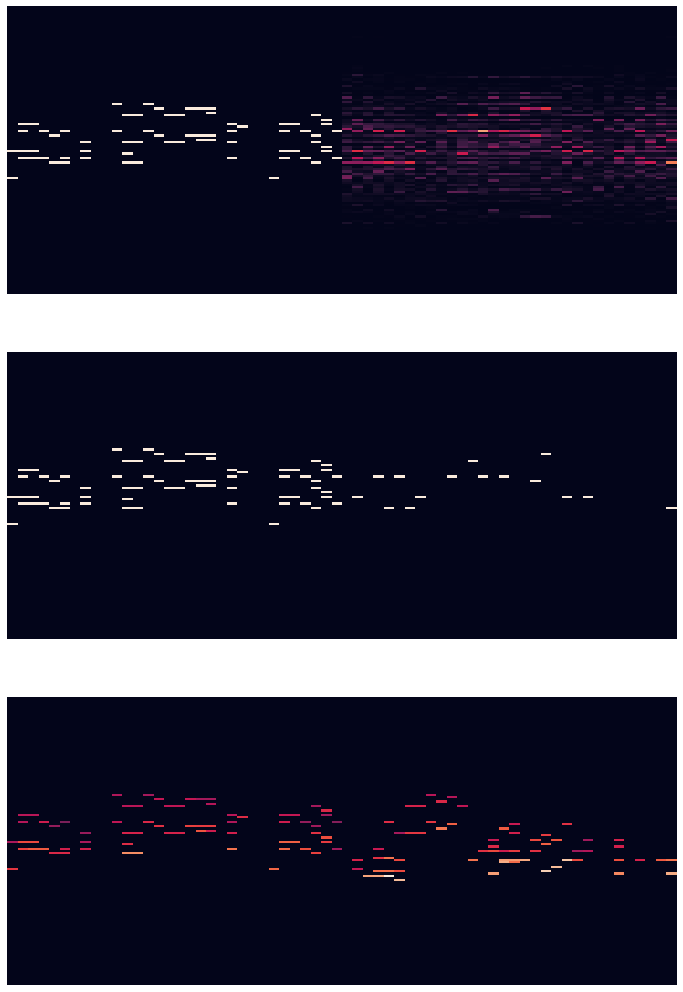

In [20]:
p_song, pred_song = net_multi.song((random_motif > 0).astype(np.float32), 1)
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
sn.heatmap(p_song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(3, 1, 2)
sn.heatmap(pred_song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(3, 1, 3)
sn.heatmap(song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[]

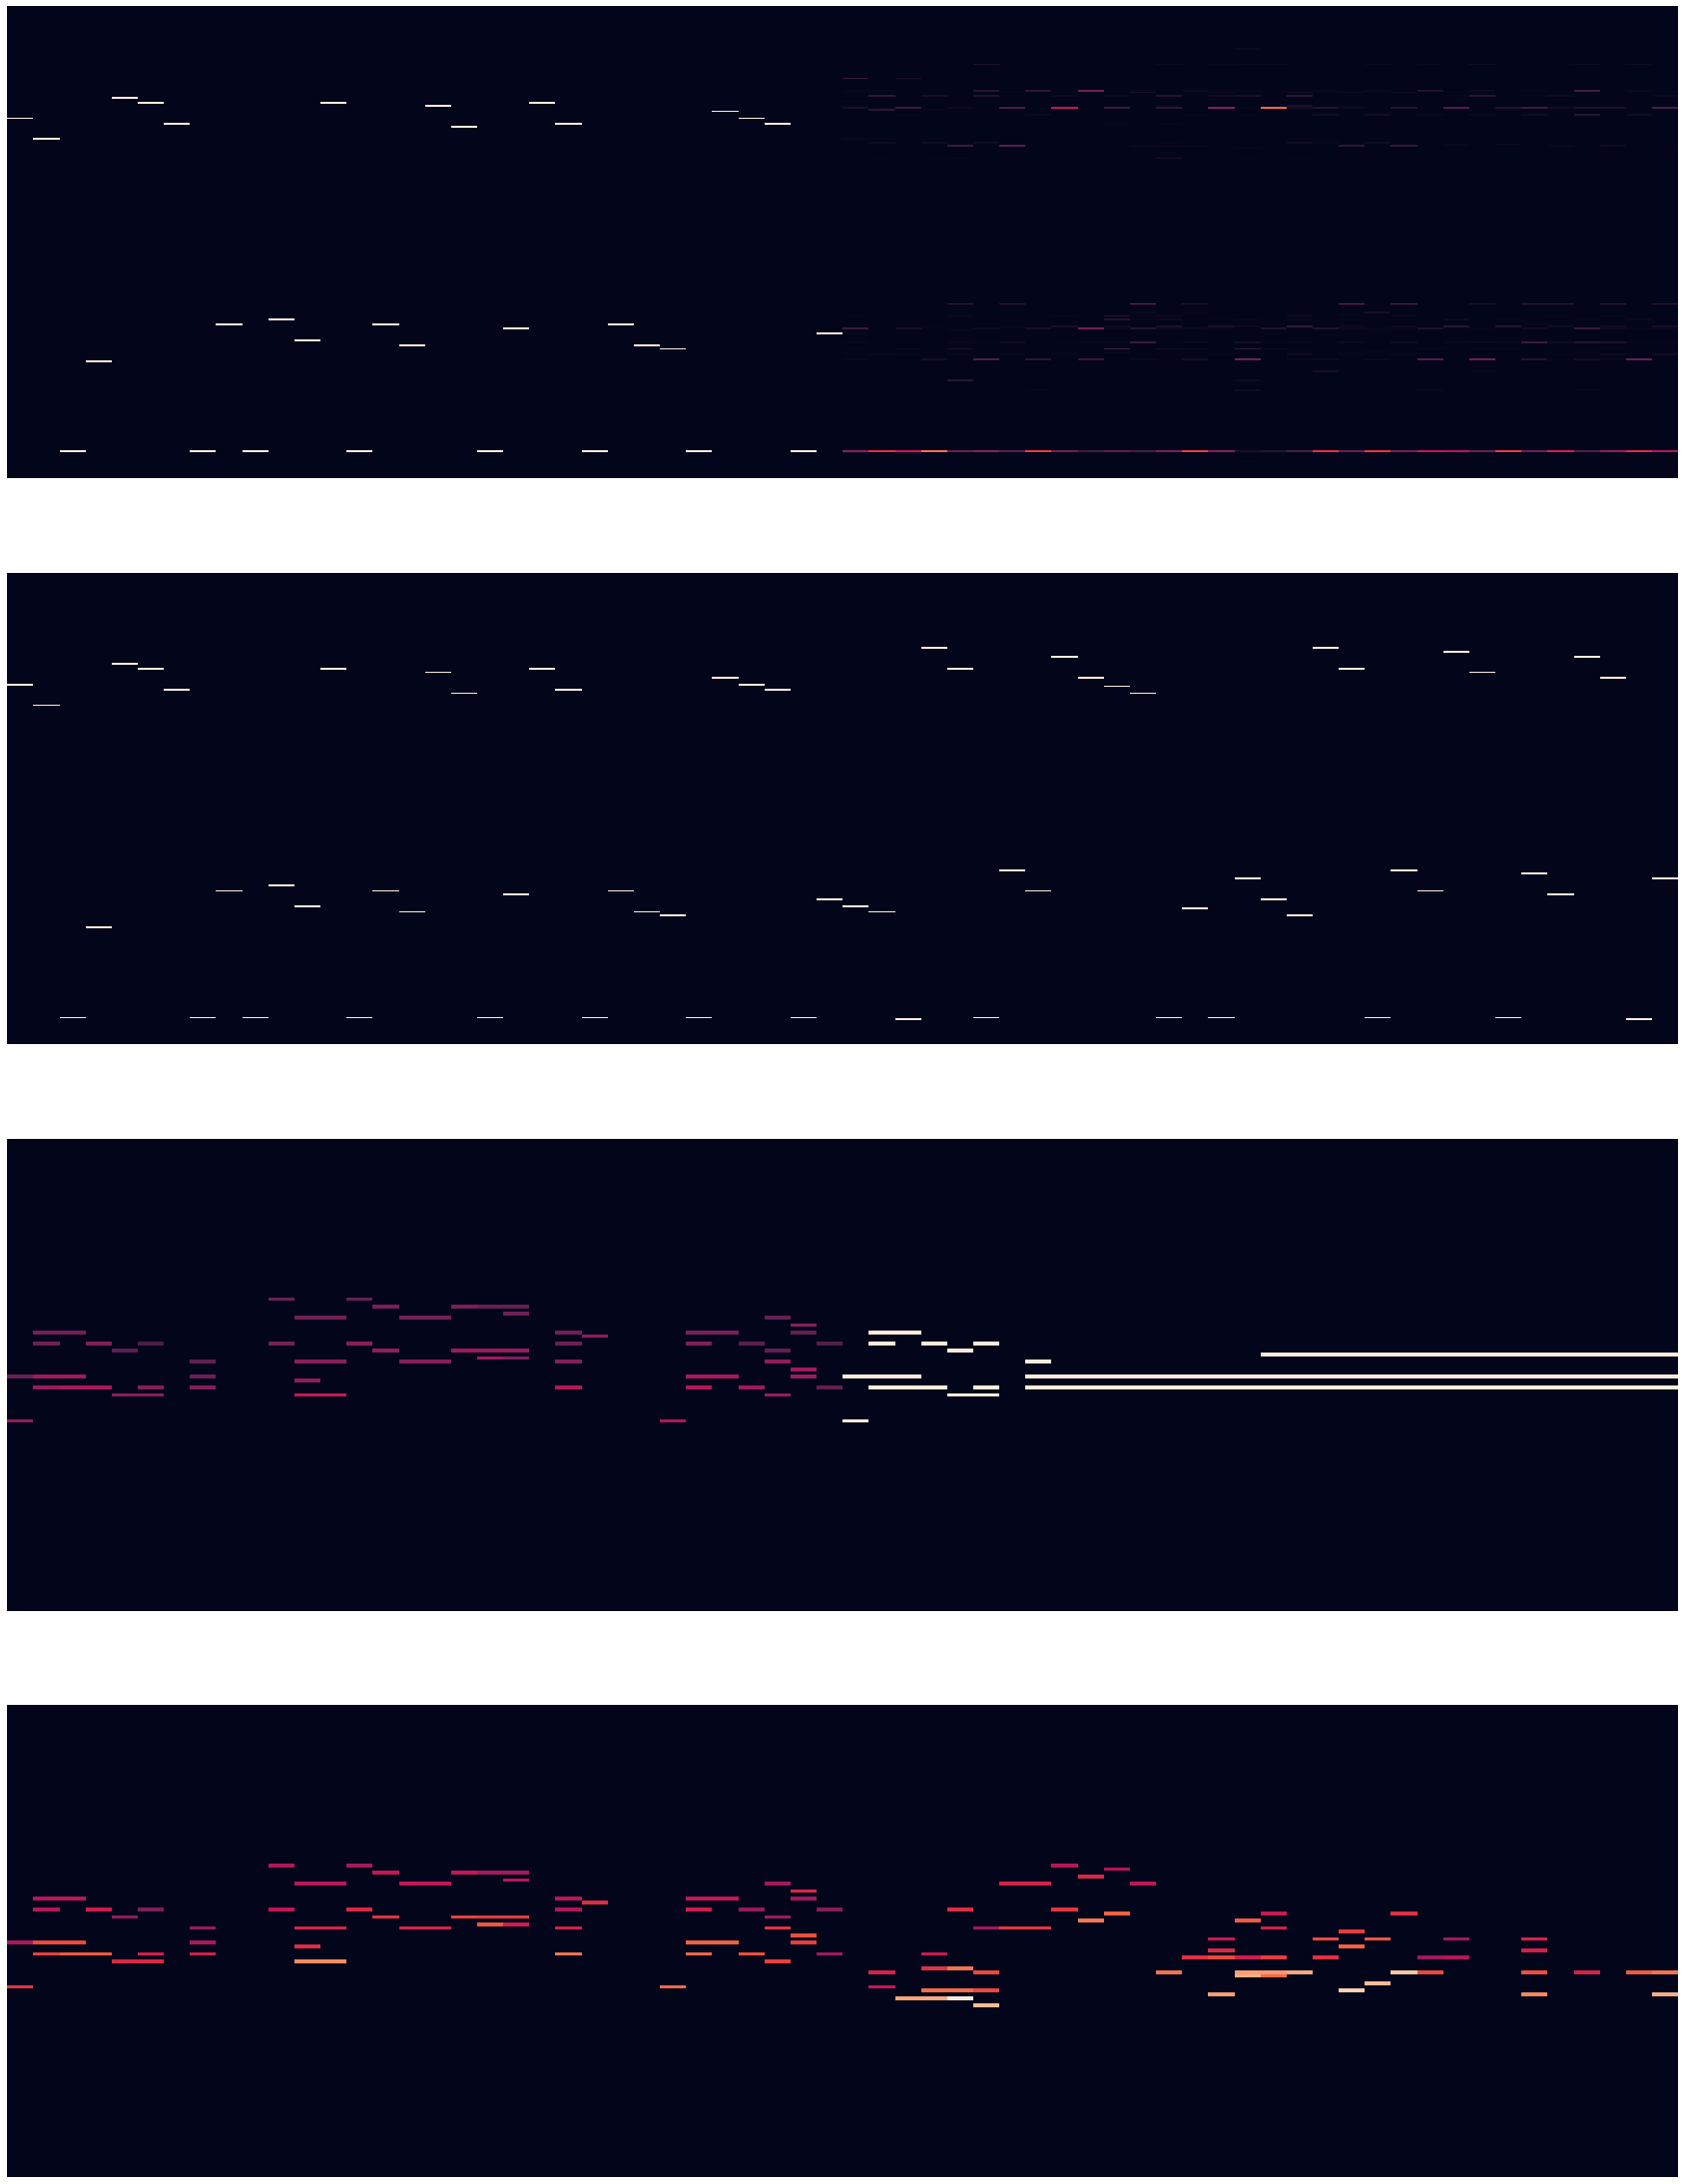

In [26]:
random_states = roll_to_state(random_motif > 0, bits, 128)
song_states = roll_to_state(random_roll > 0, bits, 128)
p_song, pred_song = net_state.song(random_states[:, :motif_size].astype(np.float32), 10)
plt.figure(figsize=(30, 40))
plt.subplot(4, 1, 1)
new_motifs = state_to_roll(pred_song, bits=bits, notes=128)
final_song = np.concatenate([
    random_motif,
    new_motifs
], axis=1)
# sn.heatmap(final_song, cbar=False)
min_size = min(song.shape[1], final_song.shape[1])
sn.heatmap(p_song[:, :motif_size * 2], vmin=0, vmax=1, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(4, 1, 3)
sn.heatmap(final_song[:, :min_size], cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(4, 1, 2)
sn.heatmap(song_states[:, :motif_size * 2], cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(4, 1, 4)
sn.heatmap(song[:, :min_size], cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])